In [1]:
#hide
#! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

## Gathering Data

In [3]:
types = 'papaya plant','chaya plant', 'papaya fruit'
path = Path('training_images')

In [10]:
if not path.exists():
    path.mkdir()
for o in types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_ddg(f'{o}',150)
    download_images(dest, urls=results)

In [4]:
fns = get_image_files(path)
fns

(#294) [Path('training_images/chaya plant/017bdb42-e934-4177-a2e3-a35d36907b31.jpg'),Path('training_images/chaya plant/0190378c-225c-48f1-86e8-c9f4dc6269c7.jpg'),Path('training_images/chaya plant/028184db-f33c-4630-a4c4-088dd97fbed1.jpg'),Path('training_images/chaya plant/03053d63-8244-4a3e-87da-399b395de9af.jpg'),Path('training_images/chaya plant/06106bc5-47fb-44bd-8e6e-867e4da4f3d5.jpeg'),Path('training_images/chaya plant/06629f49-a10d-4a00-8e73-0c36e732a4c2.jpg'),Path('training_images/chaya plant/0da8be2d-0665-4970-adb2-7983a9229177.jpg'),Path('training_images/chaya plant/1000a2e0-658f-477d-a485-56bfdad11e80.jpg'),Path('training_images/chaya plant/1181b51f-f854-42ff-a12b-286185addef2.jpg'),Path('training_images/chaya plant/134e0323-8d22-4a37-876d-038b8dfff450.JPG')...]

In [5]:
failed = verify_images(fns)
failed

(#0) []

In [8]:
failed.map(Path.unlink);

## From Data to DataLoaders

In [7]:
training_data = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [8]:
dlss = training_data.dataloaders(path)

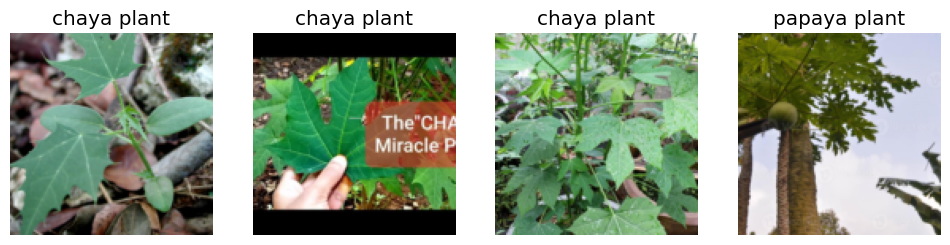

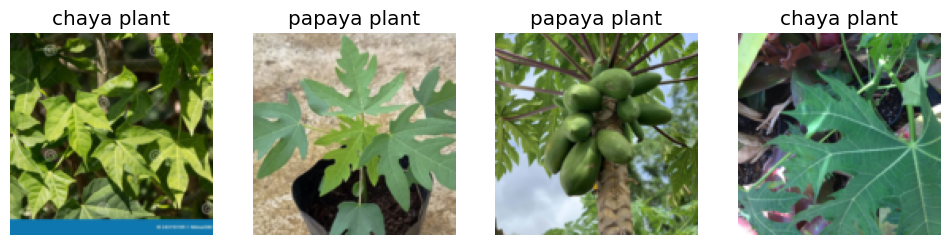

In [10]:
dlss.valid.show_batch(max_n=4, nrows=1)
dlss.train.show_batch(max_n=4, nrows=1)

C:\Users\ASUS\miniforge3\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


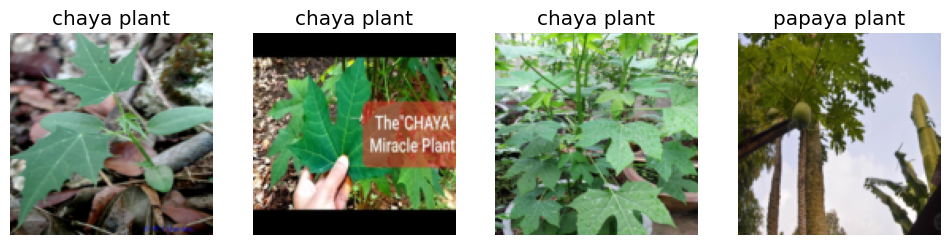

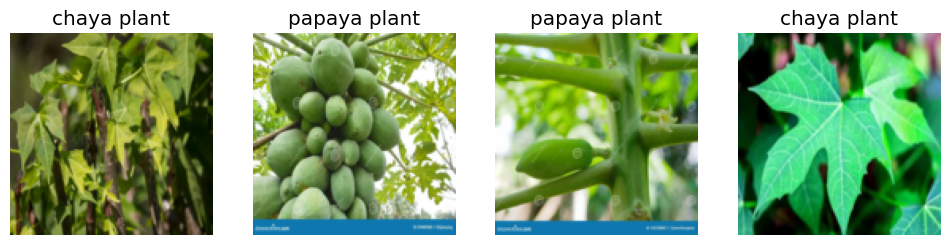

In [11]:
training_data = training_data.new(item_tfms=Resize(128, ResizeMethod.Squish))
dlss = training_data.dataloaders(path)
dlss.valid.show_batch(max_n=4, nrows=1)
dlss.train.show_batch(max_n=4, nrows=1)

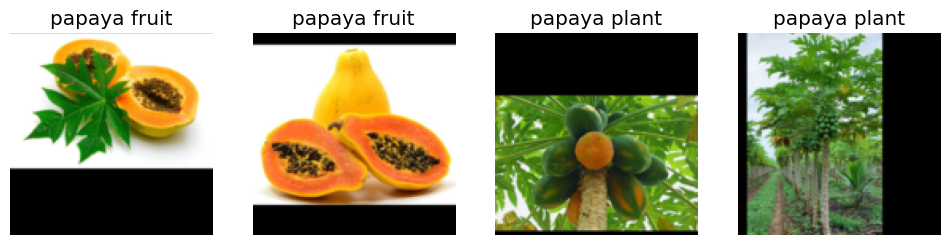

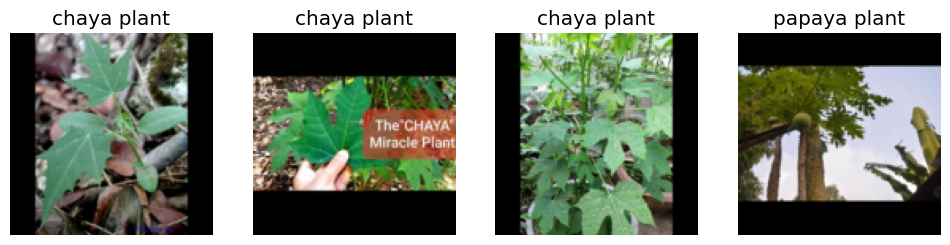

In [12]:
training_data = training_data.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dlss = training_data.dataloaders(path)
dlss.train.show_batch(max_n=4, nrows=1)
dlss.valid.show_batch(max_n=4, nrows=1)

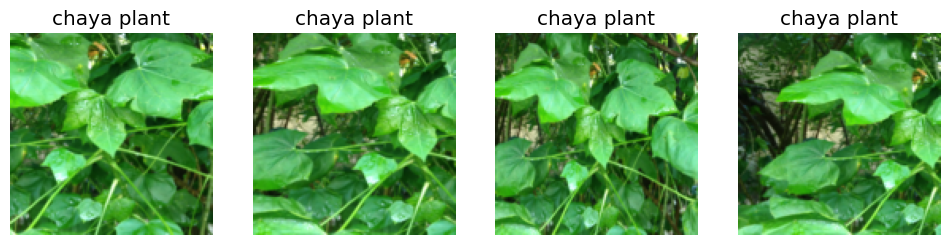

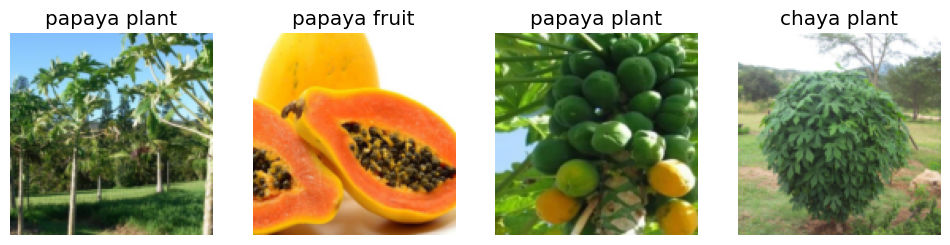

In [13]:
training_data = training_data.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dlss = training_data.dataloaders(path)
dlss.train.show_batch(max_n=4, nrows=1, unique=True)
dlss.train.show_batch(max_n=4, nrows=1)

### Data Augmentation

In [70]:
training_data = training_data.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dlss = training_data.dataloaders(path)
dlss.train.show_batch(max_n=8, nrows=2, unique=True)
dlss.train.show_batch(max_n=4, nrows=1)

TypeError: 'NoneType' object is not iterable

## Training Your Model, and Using It to Clean Your Data

In [14]:
training_data = training_data.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dlss = training_data.dataloaders(path)

In [15]:
learn = vision_learner(dlss, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.862301,1.449037,0.517241,01:03


epoch,train_loss,valid_loss,error_rate,time
0,0.858477,0.957663,0.362069,01:20
1,0.650581,0.590016,0.206897,01:19
2,0.506187,0.474750,0.155172,01:15
3,0.425887,0.441271,0.155172,01:15


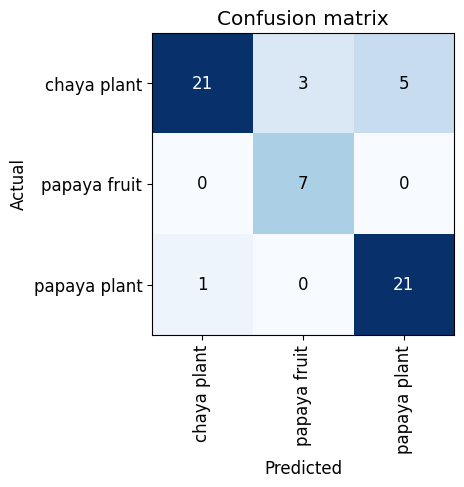

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

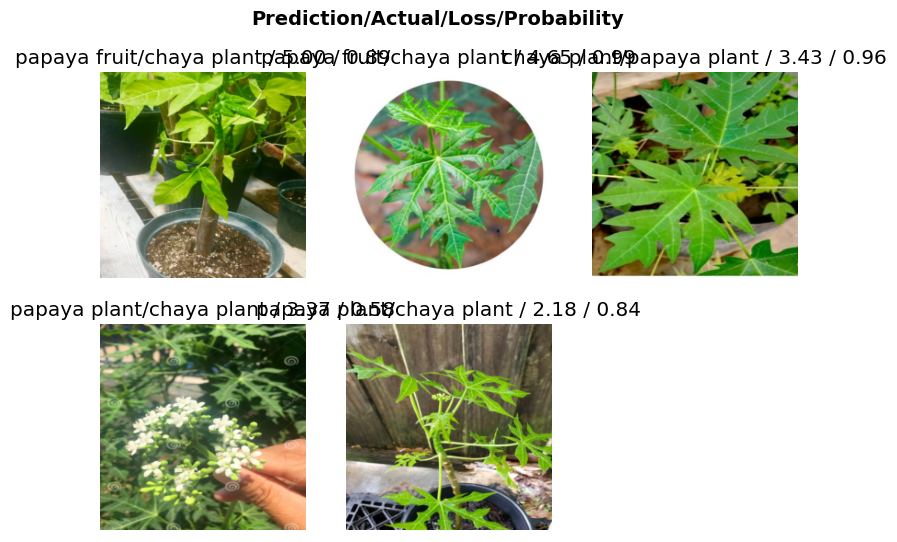

In [17]:
interp.plot_top_losses(5)

In [30]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

C:\Users\ASUS\miniforge3\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [36]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'training_images\\chaya plant\\07b2e91d-8074-4b04-bf46-18818481f475.jpg'

## Using the Model for Inference

In [65]:
path = Path('training_export')
if not path.exists():
    path.mkdir()
filename = "export.pkl"
learn.export(path/filename)

In [71]:
path.ls(file_exts='.pkl')

(#1) [Path('training_export/export.pkl')]

In [72]:
learn_inf.dls.vocab

['chaya plant', 'papaya fruit', 'papaya plant']

## [OPTIONAL] Creating Classify Button from the Model

In [49]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [50]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()

In [51]:
#hide_output
lbl_pred = widgets.Label()

In [52]:
#hide_output
btn_run = widgets.Button(description='Classify')

In [53]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [54]:
#hide_output
VBox([widgets.Label('Upload papaya or chaya plant images!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

## [NOT WORKING] Deploying your app

To show off initial prototype of the application (or any hobby projects), you can use [Binder](https://mybinder.org/). Follow these steps:

1. Add your notebook to a [GitHub repository](http://github.com/).
2. Paste the URL of that repo into Binder's URL.
3. Change the File dropdown to instead select URL.
4. In the "URL to open" field, enter `voila/render/app.ipynb`.
5. Click the clickboard button at the bottom right to copy the URL and paste it somewhere safe. 
6. Click Launch.